<a href="https://colab.research.google.com/github/yousraBRK/3D_Reconstituition_MicMac/blob/main/3D_Reconstitution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 3D

# VMI Master 2 

# BOURKICHE Yousra

Le calculs des points Homologues s'est fait grace librairie MicMac via la commande suivante :

`mm3d Tapioca All .*JPG 1000 ExpTxt=1`



In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd 
import cv2
import matplotlib.pyplot as plt  
import mm3d_utils
import math
import cv2
import glob




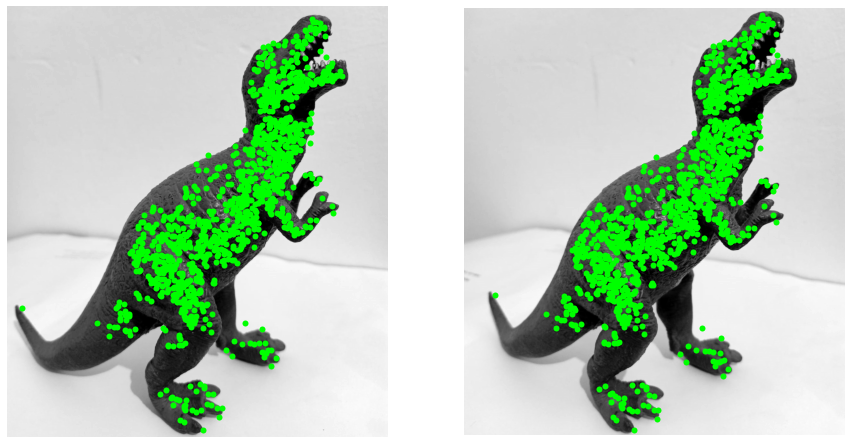

In [ ]:
aIm1 = cv2.imread('/content/DinoK1.jpg',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('/content/DinoK2.jpg',cv2.IMREAD_IGNORE_ORIENTATION) 



TPtsVec = mm3d_utils.ImportHom('/content/DinoK2.jpg.txt')

NbPts = len(TPtsVec)

 
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)]) 
mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))


# Calibration avec OpenCV


In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32) #create a matrix (2D array) of 7*7 *3 of type float32
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('/content/CalibrationImages/*.jpg')

for fname in images: 
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
print("****************************************")
print("ret :",ret)
print("****************************************")
print("camera matrix :",mtx)
print("***************************************")
print ("distortion coefficients ",dist)
print("***************************************")
print("rotation vector",rvecs)
print("***************************************")
print("translation vector",tvecs)
print("***************************************\n")



****************************************
ret : 3.76320612927565
****************************************
camera matrix : [[1.58698202e+03 0.00000000e+00 9.57283004e+02]
 [0.00000000e+00 1.57435894e+03 8.07242680e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
***************************************
distortion coefficients  [[-0.11271601  0.30375098 -0.01553024  0.00305985 -0.1913456 ]]
***************************************
rotation vector [array([[0.07166268],
       [0.0550265 ],
       [0.47116979]]), array([[-0.4197998 ],
       [ 0.0559388 ],
       [ 0.07223043]]), array([[-0.37404784],
       [-0.68542213],
       [-2.00279277]]), array([[-0.48701946],
       [-0.47155339],
       [-0.9692183 ]]), array([[-0.07401883],
       [ 0.09194251],
       [-1.54590686]]), array([[-0.06047255],
       [-0.98777806],
       [ 2.95980821]]), array([[-1.00594237],
       [ 0.30721414],
       [-2.83448563]]), array([[-0.3537823 ],
       [-0.48947233],
       [-1.50115433]]), array([

# Suppression de la distorsion 

total error:  0.48324391720475246


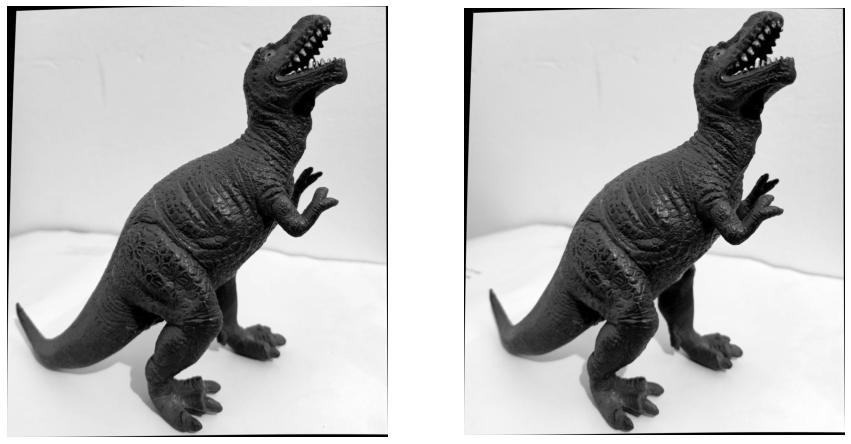

In [ ]:

imgS1=aIm1
imgS2=aIm2
h,  w = imgS1.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort

dst1=cv2.undistort(aIm1,mtx,dist,None,newcameramtx)



h,  w = imgS2.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
dst2 = cv2.undistort(aIm2, mtx, dist, None, newcameramtx)

mm3d_utils.plot_images([np.asarray(dst1),np.asarray(dst2)])


mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("total error: " ,mean_error/len(objpoints))










In [ ]:
CoeffDistInv =[0,0,0,0]
PrincipalPoint=[mtx[0,2],mtx[1,2]]
CDist = PrincipalPoint
Focale= mtx[0,0]



In [ ]:
def DistRadial(CDist,CoeffInv,P1) :
     
    Cx = P1[0] - CDist[0]
    Cy = P1[1] - CDist[1]
    Rho2 = np.square(Cx) + np.square(Cy) 
    RhoPower = Rho2
    
    dist=0
  
    for itcoef in CoeffInv:
        dist+=itcoef * RhoPower
        RhoPower*=Rho2
       
    return [ P1[0]+Cx*dist, P1[1]+Cy*dist ]
    

In [ ]:
def DirBundle(PP,F,P) :
    return [ (P[0]-PP[0])/F,(P[1]-PP[1])/F ]


In [ ]:
# Normalise image observations (image points to direction)
def Transform2DirAll(TPtsVec) :
    Res = []
    for P1,P2 in TPtsVec :
        P1 = DistRadial(CDist,CoeffDistInv,P1)
        P1 = DirBundle(P1,Focale,P1)
        P2 = DistRadial(CDist,CoeffDistInv,P2)
        P2 = DirBundle(P1,Focale,P2)
        Res.append([P1,P2])
    return Res

In [ ]:
# Calculate the sum of the residual errors
def CalcMatEssErr(MatE0) :
    a,b,c,d,e,f,g,h = MatE0 # ith element is omitted because it is =0
    
    ResSom = 0
    for Pt1, Pt2 in TPtsDir:
        x1, y1 = Pt1
        x2, y2 = Pt2
        EX2 = a*x2 + b*y2+ c
        EY2 = d*x2 + e*y2 + f
        EZ2 = g*x2 + h*y2 + 1

        Res = x1*EX2 + y1*EY2 + EZ2
        ResSom += np.square(Res)
 
    return ResSom

In [ ]:
# Normalise image points to directions
TPtsDir = Transform2DirAll(TPtsVec)

# Initialize the essential matrix with zeros
E0 = [0,0,0,0,0,0,0,0]
print("Residual error on E0 before minimization",CalcMatEssErr(E0))

E = minimize(CalcMatEssErr,E0)
print("Residual error on E0 after minimization",CalcMatEssErr(E.x),"succes ?",E.success)

# Transform the vector to a matrix
EMat = mm3d_utils.TabToMatrix(E.x)
# Print the determinant of E
print("det E0",np.linalg.det(EMat))

# TODO Calculate the SVD decomposition
U, D, V = svd(EMat)

# TODO Calculate the E by enforcing the constraint
E_constr = np.matmul(([[D[0], 0, 0], [0, D[1], 0],[0,0,0]]), V)

# Print the determinant of E
print("det E",np.linalg.det(E_constr))

# Print the final Essential matrix
print("E",E_constr)


Residual error on E0 before minimization 1069.0
Residual error on E0 after minimization 14.58158269077964 succes ? True
det E0 0.0
det E 0.0
E [[-1.5163177  -0.92258917  1.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [ ]:
def Cam2WToW2Cam(R,C) :

    ROut = np.linalg.inv(R)
    tOut = -np.matmul(ROut,C)
    
    return ROut,tOut

In [ ]:
Z =  np.array([[0, 1, 0], [-1, 0, 0], [0,0,0]])
W =  np.array([[0, -1, 0], [1, 0, 0], [0,0,1]])

# TODO - Decompose the E matrix to U D V^t with svd 
U,D,VT = svd(E_constr) 

# TODO- calculate S
S =  np.matmul(np.matmul(U,Z), U.T)
print("S",S)
      
# TODO - Write the 2 solutions to translation and 2 solutions to rotation as camera to world transformations
# Translational part
C_Cam2_v1 =  U.dot([[0],[0],[1]])
C_Cam2_v2 = -U.dot([[0],[0],[1]])
print("C_Cam2_v1",C_Cam2_v1)
print("C_Cam2_v2",C_Cam2_v2)

# Rotational part
RC2W_Cam2_v1 =  np.matmul(U, np.matmul(W, VT))
RC2W_Cam2_v2 =  np.matmul(U, np.matmul(W.T, VT))
print("RC2W_Cam2_v1",RC2W_Cam2_v1)
print("RC2W_Cam2_v2",RC2W_Cam2_v2)

# Transform the camera to world into world to camera transformation
RCam2_v1,tCam2_v1 = Cam2WToW2Cam(RC2W_Cam2_v1,C_Cam2_v1)
print("R21 1",RCam2_v1)
print("t21 1",tCam2_v1)

RCam2_v2,tCam2_v2 = Cam2WToW2Cam(RC2W_Cam2_v1,C_Cam2_v2)
print("\nR21 2",RCam2_v2)
print("t21 2",tCam2_v2)

RCam2_v3,tCam2_v3 = Cam2WToW2Cam(RC2W_Cam2_v2,C_Cam2_v1)
print("\nR21 3",RCam2_v3)
print("t21 3",tCam2_v3)

RCam2_v4,tCam2_v4 = Cam2WToW2Cam(RC2W_Cam2_v2,C_Cam2_v2)
print("\nR21 4",RCam2_v4)
print("t21 4",tCam2_v4)

S [[ 0.  0.  1.]
 [ 0.  0.  0.]
 [-1.  0.  0.]]
C_Cam2_v1 [[0.]
 [1.]
 [0.]]
C_Cam2_v2 [[-0.]
 [-1.]
 [-0.]]
RC2W_Cam2_v1 [[ 0.         -0.73498209 -0.67808652]
 [ 0.66784977 -0.50469715  0.5470443 ]
 [-0.7442961  -0.45285993  0.49085762]]
RC2W_Cam2_v2 [[ 0.          0.73498209  0.67808652]
 [ 0.66784977 -0.50469715  0.5470443 ]
 [ 0.7442961   0.45285993 -0.49085762]]
R21 1 [[-0.          0.66784977 -0.7442961 ]
 [-0.73498209 -0.50469715 -0.45285993]
 [-0.67808652  0.5470443   0.49085762]]
t21 1 [[-0.66784977]
 [ 0.50469715]
 [-0.5470443 ]]

R21 2 [[-0.          0.66784977 -0.7442961 ]
 [-0.73498209 -0.50469715 -0.45285993]
 [-0.67808652  0.5470443   0.49085762]]
t21 2 [[ 0.66784977]
 [-0.50469715]
 [ 0.5470443 ]]

R21 3 [[ 0.          0.66784977  0.7442961 ]
 [ 0.73498209 -0.50469715  0.45285993]
 [ 0.67808652  0.5470443  -0.49085762]]
t21 3 [[-0.66784977]
 [ 0.50469715]
 [-0.5470443 ]]

R21 4 [[ 0.          0.66784977  0.7442961 ]
 [ 0.73498209 -0.50469715  0.45285993]
 [ 0.67808652 

In [ ]:
def Triangulation(R1,t1,R2,t2,TiePoints):

    P1 = np.ones([3,4],dtype=float)
    P1[0:3,0:3] = R1
    P1[0:3,3:4] = t1
    #print("P1",P1)
    
    P2 = np.ones([3,4],dtype=float)
    P2[0:3,0:3] = R2
    P2[0:3,3:4] = t2
    #print("P2",P2)
     
    Result = []
    for Pt1,Pt2 in TiePoints:
        x1,y1=Pt1
        x2,y2=Pt2
        #A
        A=np.zeros([4,4],dtype=float)
        A[0,0:4]= x1*P1[2,:]-P1[0,:] #x1
        A[1,0:4]= y1*P1[2,:]-P1[1,:]
        A[2,0:4]= x2*P2[2,:]-P2[0,:]
        A[3,0:4]= y2*P2[2,:]-P2[1,:]
        U,D,Vt = svd(A)
        V=Vt.transpose()
        #print(V[0:4,3])
        #the 3D coordinates of the point are the last column of V
        #the result is a 4x1 vector(X,Y,Z,w) of inmomogenous...
        
        Result.append([V[0:3,3]/V[3,3]])
        
    return Result

In [ ]:

# TODO - Define the projection matrix for camera 1
RCam1 =  np.eye(3,3,dtype=float)
tCam1 =  [[0],[0],[0]]

Structure3D_v1 = Triangulation(RCam1,tCam1,RCam2_v1,tCam2_v1,TPtsDir)
Structure3D_v2 = Triangulation(RCam1,tCam1,RCam2_v2,tCam2_v2,TPtsDir)
Structure3D_v3 = Triangulation(RCam1,tCam1,RCam2_v3,tCam2_v3,TPtsDir)
Structure3D_v4 = Triangulation(RCam1,tCam1,RCam2_v4,tCam2_v4,TPtsDir)

print(Structure3D_v1[0][:])
print(Structure3D_v2[0][:])
print(Structure3D_v3[0][:])
print(Structure3D_v4[0][:])

# Get the intensity for each point
RGB = mm3d_utils.GetIntensity(TPtsVec,dst1,dst2) 

Structure3D_v1 = np.asarray(Structure3D_v1).reshape(1069, 3)
Structure3D_v2 = np.asarray(Structure3D_v2).reshape(1069, 3)
Structure3D_v3 = np.asarray(Structure3D_v3).reshape(1069, 3)
Structure3D_v4 = np.asarray(Structure3D_v4).reshape(1069, 3)

# Save to ply
mm3d_utils.SaveToPly("Structure3D1.ply",Structure3D_v1,RGB)
mm3d_utils.SaveToPly("Structure3D2.ply",Structure3D_v2,RGB)
mm3d_utils.SaveToPly("Structure3D3.ply",Structure3D_v3,RGB)
mm3d_utils.SaveToPly("Structure3D4.ply",Structure3D_v4,RGB) 

[array([0.16537356, 0.59902849, 0.005083  ])]
[array([-0.16537356, -0.59902849, -0.005083  ])]
[array([-0.16537356,  0.59902849, -0.005083  ])]
[array([ 0.16537356, -0.59902849,  0.005083  ])]
ddd  (1069, 2, 2)
